# DIverse Counterfactual Explanations (DICE)

In this tutorial, you will learn how to implement a specific type of post-hoc explanations: counterfactual explanations. But what do counterfactual explanations mean?. This kind of explanations is intended to show how the model works by creating hypothetical examples  with a prediction with respect to the initial studied instance (e.g., a consumer). In order to do so, we are going to focus on the application of DiCE(original article: Mothilal et al.[[1](https://arxiv.org/pdf/1905.07697.pdf)]) using the framework developped by Mothilal, Sharma and Tan https://github.com/interpretml/DiCE.



## How DiCE generate counterfactual explanations?

The main idea is to generate a set of k counterfactual examples $\{c_1, c_2, ..., c_k\}$ such the decision of the model $f$ given an instance $x$ changes. However, we have to take into account that generating counterfactual examples with a high number of features that have changed is not the ideal approach (Diversity). In the other hand we need to consider counterfactual examples that are close to the original instance $x$ (Proximity) otherwise the explanations will not be useful.

Diversity via Determinantal Point Process:

\begin{gather}
dpp\_diversity  = det(K)
\end{gather}
where $K_{i,j} = \frac{1}{1+dist(c_i,c_j)} $ and $dist(c_i,c_j)$ is a distanc metric.

Proximity:
\begin{gather}
Proximity  := -\frac{1}{k} \sum_{i=1}^{k} dist(c_i, x)
\end{gather}

Beyond these main constraints, DiCE allows us to implement constraints that are related to "real world" problems (e.g., an upper bound for some variables)


Based on these definitions DiCE considers the next loss function to be optimized.

\begin{gather}
C(x)  = arg\;min_{c_1, c_2, ..., c_k} \frac{1}{k}\sum_{i=1}^{k} yloss(f(c_i), y) + \frac{\lambda_1}{k} \sum_{i=1}^{k} dist(c_i, x) \\ - \lambda_2 dpp\_diversity(c_1, c_2, ..., c_k)
\end{gather}

where $yloss()$ is a function that measures the distance between $f(c_i)$ and the desired outcome $y$. Both $\lambda_1$ and $\lambda_2$ are hyperparameters that balance the three parts of the loss function.

## Use Case: Credit Scoring

Now we understand how to generate counterfactual explanations, let's focus on a familiar use case in which counterfactual examples are really interesting: credit scoring.

Credit Scoring refers to algorithms used to assess the credit worthiness of a person or, more generally, an entity (company, person, etc.).

Why are we interested in applying DiCE to the machine learning based credit scoring algorithms? Credit scoring algorithms are used to estimate the probability of not repaying a credit (probability of default). In other words, they are used to approve or deny credit. For example, if one asks for a credit or a loan in the bank, one would like to know why it is refused, but also what do you have to do to improve your economy in order to in the future have a loan application approved. This is why such explanations are relevant.

The use case is organized as follows:
1. We load the pre-processed data and analyze it.
2. We compare two different tree-based models used for the Credit Scoring : XGBoost  developed by Chen et al. [[2](https://arxiv.org/abs/1603.02754)] and Random Forest developed by Breiman [[3](https://doi.org/10.1023/A:1010933404324)].
3. We apply DiCE to generate counterfactual explanations (https://github.com/interpretml/DiCE
).


### Loading and processing the original data

We are going to use a dataset provided by a ML competition hosted by Zindi (https://zindi.africa/competitions/data-science-nigeria-challenge-1-loan-default-prediction)

In [1]:
#Set up for plotting results
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
#Clone the github repository that contains all the data and the functions used to clean and prepare the data
! git clone https://github.com/ayoubelqadi/Loan-Default-Prediction.git

Cloning into 'Loan-Default-Prediction'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 69 (delta 15), reused 35 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (69/69), 3.12 MiB | 11.29 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
#Loaded pandas, numpy and matplotlib.
#The code demands the user to chose between one hot encoding and delete categorical variables.
%run /content/Loan-Default-Prediction/code/data_processing.py

**Created variables in the workspace: data_processing.py**

*DataFrames:*
1. train_perf: Original dataframe with information about loans performance, it contains the information about the loan demanded by the client.
2. train_prevloan: Contains the customer historic loans.
3. train_demographics: Contains the demographic data of the customer.
4. demographics: Contains cleaned  demographic information.
5. prevloans: Cleaned information about previous loans.
6. perf: Cleaned data on loan information.
7. final_data: Contains data used for predicting default. Results of merging the 4, 5, 6 tables using the customer as key.



The features used for building the model are as follows:


- *loannumber*: Number of loans demanded previously by the consumer (considering the current demand).
- *loanamount*: Amount of the loan.
- *totaldue*: Amount to return by the consumer.
- *termdays*: The length of time it will take for a loan to be completely paid off.
- *good_bad_flag*: Target variable representing whether the consumer has repaid the loan or not.
- *interest*: Amount the consumer has to pay in interest.
- *interest_rate*: Loan interest rate.
- *age*: Age.
- *bank_account_type*: The kind of bank account the client has.
- *longitude_gps*: Longitude localization.
- *latitude_gps*: Latitude localization.
- *bank_name_clients*: Name of the bank.
- *employment_status_clients*: Employment status of the applicant.
- *loanamount_mean*: Mean of previous loans.
- *totaldue_mean*: Mean amounts due on previous loans.
- *termdays_mean*: Mean term days on previous loans.
- *interest_mean*: Mean interest of previous loans.
- *interest_rate_mean*: Mean interest rate of previous loans.
- *diff_firstrepaiddate_firstduedate_mean*: Average delay in the first payment of the loan -divided by 365- of previous loans.
- *diff_closeddate_creationdate_mean*: Mean difference between the date a previous loan was closed and the day the loan was created.
- *repaid_dayofweek_mean*: Mean weekday on which previous loans  were repaid (0: Monday ... 6: Sunday);
- *due_dayofweek_mean*: Mean weekday on which previous loans were to be repaid.




### Taking a first look at the data

The goal is to predict whether a customer will pay back the loan.(https://zindi.africa/competitions/data-science-nigeria-challenge-1-loan-default-prediction). In this case the target variable is the variable **good_bad_flag**. We are going to set **good_bad_flag** to 1 if it is a bad loan (non repaid loan).
Let's check how many "bad loan applications" we have in the dataset:

In [4]:
X = final_data.copy()
#Redefine target
X['good_bad_flag'] = X['good_bad_flag'].apply(lambda x: 1 if x==0 else 0)

In [5]:
X['good_bad_flag'].value_counts()

,count
good_bad_flag,
0,2560
1,712


Text(0.5, 1.0, 'Class distribution')

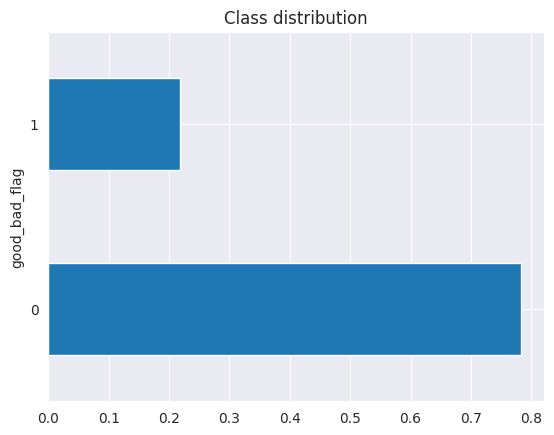

In [6]:
X['good_bad_flag'].value_counts(normalize=True).plot(kind='barh')
plt.title('Class distribution')

### Data Processing and Modeling

We are going to create two different models (Random Forest and XGBoost). First we encode categorical features, which are bank_name_clients, employment_status_clients, and bank_account_type by using one hot encoding. Then we will check how good our model is.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [9]:
x = X.drop(columns=['good_bad_flag'])#.to_numpy()
y = X['good_bad_flag']#.to_numpy(dtype=np.int)
#We use the 70% of the data to train the model and the 30% to test the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=27)

In [10]:
#Define the categorical and numerical features
categoric_features = ['bank_name_clients', 'employment_status_clients', 'bank_account_type']
numeric_features = x.columns.difference(categoric_features)
#Define the encoder for categorical values
categorical_transformer = Pipeline(steps=[
                                          ('onehot', OneHotEncoder())
])
#Define the strategy to apply to numerical data
numeric_transformer = Pipeline(steps=[
                                      ('standard_scaler', StandardScaler())
])
#Transformer:  takes the original data and transform categorical and numerical features
preprocessor = ColumnTransformer(transformers=[
                                               ('numeric', numeric_transformer, numeric_features),
                                               ('categorical', categorical_transformer, categoric_features)
])


**Random Forest**

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
#Define the weights for each class
w0 = sum(y==0)/np.bincount(y).sum()
w1 = sum(y==1)/np.bincount(y).sum()
rf_params = {
    'n_estimators': 1000,
    'max_depth': 20,
    'n_jobs': -1,
    'class_weight': {0:w0, 1:w1},
    'random_state': 27
}

In [13]:
#Model object: takes original data, processes it and applies the random forest
clf_rf = Pipeline(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(**rf_params))
])

In [14]:
#Train the model
rf_model = clf_rf.fit(x_train, y_train)

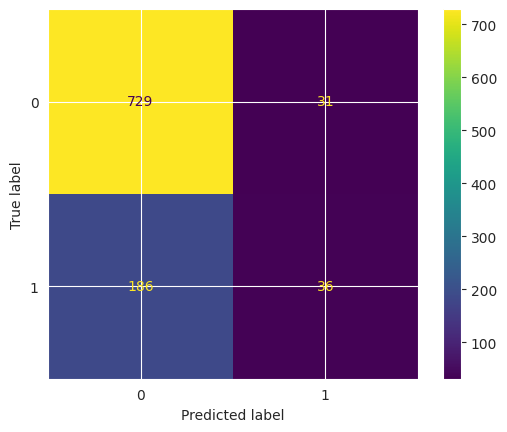

In [17]:
#Model assessment
ConfusionMatrixDisplay.from_estimator(rf_model, x_test, y_test, values_format='.3g')

**XGBoost**

In [18]:
#Loading the libraries that we need to build our model
import xgboost as xgb

In [19]:
#We create a dictionary that contains our model hyperparameters
params_xgb = {
    'n_estimators': 1000,
    'learning_rate': 0.1,
    'subsample': 0.8,
    #'reg_alpha': 1,
    'max_depth': 10,
    'objective': 'binary:logistic',
    'scale_pos_weight': 5
}
clf_xgb = Pipeline(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier(**params_xgb))
])

clf_xgb = clf_xgb.fit(x_train, y_train)


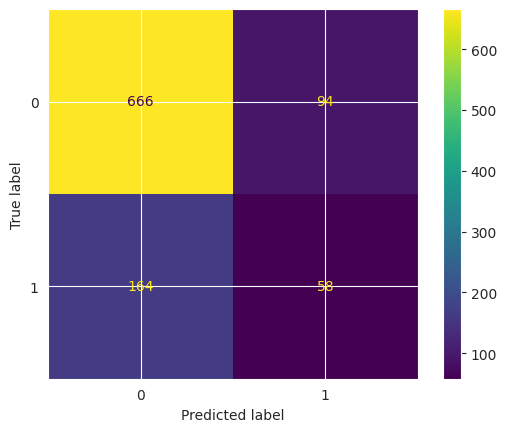

In [20]:
ConfusionMatrixDisplay.from_estimator(clf_xgb, x_test, y_test, values_format='.3g')

### DiCE

In [21]:
#If DICE is not installed
! pip install dice-ml

In [22]:
#Loading the dice module
import dice_ml
from dice_ml.utils import helpers
import json

In [23]:
#DiCE data object
data = dice_ml.Data(dataframe=X, continuous_features=list(numeric_features), outcome_name='good_bad_flag')
#DiCE model object
model_exp = dice_ml.Model(model=rf_model, backend='sklearn')
#Creates the explanations
exp = dice_ml.Dice(data, model_exp, method="random")

In [24]:
#We take an example of our training set
#We set the number of counterfactual explanations to 2.
e1 = exp.generate_counterfactuals(x_train[354:355], total_CFs=2, desired_class="opposite")
#Show counterfactual explanations
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:02<00:00,  2.62s/it]

Query instance (original outcome : 0)


,loannumber,loanamount,totaldue,termdays,interest,interest_rate,age,bank_account_type,longitude_gps,latitude_gps,...,loanamount_mean,totaldue_mean,termdays_mean,interest_mean,interest_rate_mean,diff_firstrepaiddate_firstduedate_mean,diff_closeddate_creationdate_mean,repaid_dayofweek_mean,due_dayofweek_mean,good_bad_flag
0,3,10000.0,13000.0,30,3000.0,30.0,40,Current,7.354188,5.13684,...,10000.0,12250.0,0.06,2250.0,22.5,0.0,24.0,4.5,1.0,0



Diverse Counterfactual set (new outcome: 1)


,loannumber,loanamount,totaldue,termdays,interest,interest_rate,age,bank_account_type,longitude_gps,latitude_gps,...,loanamount_mean,totaldue_mean,termdays_mean,interest_mean,interest_rate_mean,diff_firstrepaiddate_firstduedate_mean,diff_closeddate_creationdate_mean,repaid_dayofweek_mean,due_dayofweek_mean,good_bad_flag
0,-,-,-,-,-,-,-,-,63.494667,-,...,-,-,-,-,-,94.7,-,-,-,1
1,-,-,-,-,-,-,-,-,-,38.372696,...,-,-,-,-,-,-,54.1,-,-,1


In this particular case we selected a person considered by our credit scoring model as solvent person. Both considered counterfactual explanations show that if historically the person  delayed the payment of its previous loans, the loan would be denied.

In [25]:
#We take an example of our training set
#We set the number of counterfactual explanations to 2.
#First of all we are going to define which features are easier to vary from a human stand point
#static_features = ['loanamount', 'totaldue', 'termdays', 'interest', 'age', 'interest_rate', 'longitude_gps', 'longitude_gps', 'loannumber']
#features_to_vary = x.columns.difference(static_features)
index_client = 398
features_to_vary = ['loanamount', 'employment_status_clients', 'diff_firstrepaiddate_firstduedate_mean']
#generate the counterfactuals
e2 = exp.generate_counterfactuals(x[index_client:index_client+1],
                                  total_CFs=3, desired_class="opposite",
                                  random_seed=30000,
                                  features_to_vary=list(features_to_vary),
                                  permitted_range={'employment_status_clients': ['Permanent', 'Self-Employed'],
                                                   'loanamount': [10000, 30000],
                                                   'diff_firstrepaiddate_firstduedate_mean': [-30, 30]},
                                  )
#Show counterfactual explanations
e2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:03<00:00,  3.29s/it]

Query instance (original outcome : 1)


,loannumber,loanamount,totaldue,termdays,interest,interest_rate,age,bank_account_type,longitude_gps,latitude_gps,...,loanamount_mean,totaldue_mean,termdays_mean,interest_mean,interest_rate_mean,diff_firstrepaiddate_firstduedate_mean,diff_closeddate_creationdate_mean,repaid_dayofweek_mean,due_dayofweek_mean,good_bad_flag
0,6,30000.0,34500.0,30,4500.0,15.0,30,Other,8.113206,6.324524,...,18000.0,20850.0,0.056,2850.0,15.75,-2.2,19.200001,2.2,1.6,1



Diverse Counterfactual set (new outcome: 0)


,loannumber,loanamount,totaldue,termdays,interest,interest_rate,age,bank_account_type,longitude_gps,latitude_gps,...,loanamount_mean,totaldue_mean,termdays_mean,interest_mean,interest_rate_mean,diff_firstrepaiddate_firstduedate_mean,diff_closeddate_creationdate_mean,repaid_dayofweek_mean,due_dayofweek_mean,good_bad_flag
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0
1,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,4.1,-,-,-,0
2,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-20.4,-,-,-,0


In [26]:
def get_explanations(explanations, features_varied=[]):
  features_varied = features_varied.copy()
  #Get the explanations as a json object
  inf = json.loads(explanations.to_json())
  exp_list = inf['cfs_list'][0]
  #Get the original instance
  original_instance = inf['test_data']
  #feature names
  feature_name_dict = {}
  feature_names = inf['feature_names']
  for i, item in enumerate(feature_names):
    feature_name_dict[i] = item
  feature_name_dict[len(feature_names)] = 'good_bad_flag'
  features_varied.append('good_bad_flag')
  #Get the explanations and convert the results to a dataframe
  exp_dict = {}
  exp_dict[0] = original_instance[0][0]
  for i in range(len(exp_list)):
    exp_dict[i+1] = exp_list[i]
  #Create a dataframe with the results
  cf_df = pd.DataFrame.from_dict(data=exp_dict, orient='index')
  cf_df = cf_df.rename(columns=feature_name_dict)
  return cf_df[features_varied]

In [32]:
cf_df = get_explanations(e2, features_varied=features_to_vary)
cf_df['good_bad_flag'] = cf_df['good_bad_flag'].apply(lambda x: 'Approved' if x==0.0 else 'Denied')

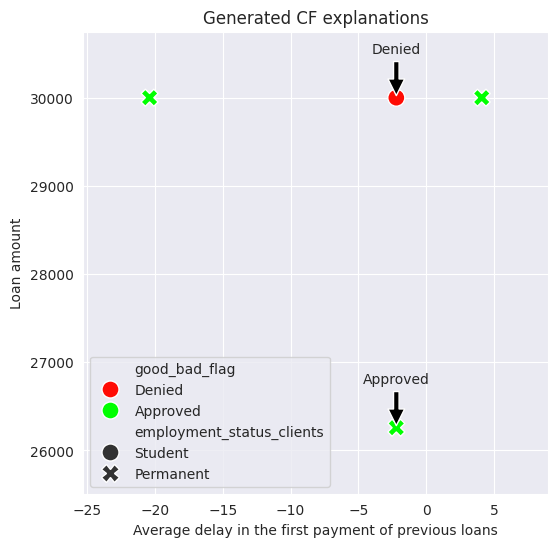

In [33]:
colors = ["#FF0B04","#00FF00"]
palette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(6, 6))

g = sns.scatterplot(data=cf_df,
                x="diff_firstrepaiddate_firstduedate_mean",
                y="loanamount",
                palette=palette,
                hue="good_bad_flag",
                style="employment_status_clients",
                s=150
                )
x = cf_df.iloc[1,[0,2]].values[1]
y = cf_df.iloc[1,[0,2]].values[0]

ax.annotate('Denied', xy=(-2.2, 30000),  xycoords='data',
            xytext=(0,40),textcoords="offset points",
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top',
            )
ax.annotate('Approved', xy=(x, y),  xycoords='data',
            xytext=(0,40),textcoords="offset points",
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top',
            )
x_max = cf_df['diff_firstrepaiddate_firstduedate_mean'].max()
x_min = cf_df['diff_firstrepaiddate_firstduedate_mean'].min()
delta_x = x_max-x_min
y_max = cf_df['loanamount'].max()
y_min = cf_df['loanamount'].min()
delta_y = y_max-y_min
ax.set_xlim([x_min-delta_x/5, x_max+delta_x/5])
ax.set_ylim([y_min-delta_y/5, y_max+delta_y/5])
ax.set_xlabel('Average delay in the first payment of previous loans')
ax.set_ylabel('Loan amount')
plt.title('Generated CF explanations')
plt.savefig('CF_explanations.png', bbox_inches='tight')